In [1]:
!pip install datasets scikit-multilearn transformers
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/

target_labels = ["happiness", "surprise", "disgust", "anger", "neutral"]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 35.6 MB/s 
     |████████████████████████████████| 89 kB 9.7 MB/s 
     |████████████████████████████████| 5.5 MB 60.1 MB/s 
     |████████████████████████████████| 182 kB 68.4 MB/s 
     |████████████████████████████████| 212 kB 57.8 MB/s 
     |████████████████████████████████| 115 kB 51.6 MB/s 
     |████████████████████████████████| 127 kB 35.6 MB/s 
     |████████████████████████████████| 7.6 MB 23.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


#Reformat and Save Datasets

##Process and save emotion data as csv for manual labelling

In [2]:
from datasets import load_dataset
target_labels = ["happiness", "surprise", "disgust", "anger", "neutral"]

def map_data_to_column(example):
  if example['label'] is 1:
    example['happiness'] = 1
  if example['label'] is 3:
    example['anger'] = 1
  if example['label'] is 5:
    example['surprise'] = 1
  return example

datasets_emotion = load_dataset("emotion")
emotion_dataset = datasets_emotion.get("train")
emotion_dataset = emotion_dataset.select(range(500))
dummy_values = [0] * len(emotion_dataset)
for label in target_labels:
  emotion_dataset = emotion_dataset.add_column(label, dummy_values)
emotion_dataset = emotion_dataset.map(map_data_to_column)
emotion_dataset = emotion_dataset.remove_columns(['label'])

emotion_dataset_csv_path = 'emotion.csv'
emotion_dataset.to_csv(emotion_dataset_csv_path, index=False)  

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

56641

##Process and save go emotions dataset

In [3]:
from datasets import load_dataset, concatenate_datasets
def reformat_go_emotions():
  datasets_go_emotions = load_dataset("go_emotions", "raw")
  dataset_list = []
  
  for go_dataset in datasets_go_emotions:
    go_dataset = datasets_go_emotions.get(go_dataset)
    go_dataset = go_dataset.rename_column("joy", "happiness")
    qualifying_data_index = []
    for go_index, go_data in enumerate(go_dataset):
      sum_of_target_labels = 0
      for label in target_labels:
        sum_of_target_labels += go_data[label]
      if sum_of_target_labels >= 1:
        qualifying_data_index.append(go_index)
    go_dataset = go_dataset.select(qualifying_data_index)
    dataset_list.append(go_dataset)
  filtered_dataset = concatenate_datasets(dataset_list)
  
  features_to_keep = target_labels + ['text']
  for feature in filtered_dataset.features:
    if feature not in features_to_keep:
      filtered_dataset = filtered_dataset.remove_columns([feature])
  return filtered_dataset

In [4]:
go_emotions_dataset = reformat_go_emotions()
go_emotions_dataset_csv_path = "go_emotions.csv"
go_emotions_dataset.to_csv(go_emotions_dataset_csv_path, index=False)  

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/raw/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#Preprocess Dataset

##Import datasets from fs 

In [5]:
from datasets import load_dataset

go_emotions_dataset_csv_path = "go_emotions.csv"
labelled_emotion_dataset_csv_path = "labelled_emotion.csv"

go_emotions_dataset = load_dataset("csv", data_files=go_emotions_dataset_csv_path)['train'].select(range(2000))
emotion_dataset = load_dataset("csv", data_files=labelled_emotion_dataset_csv_path)['train']

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-10cd9b2c244de602/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-83e4f5dd6806defb/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
from datasets import concatenate_datasets
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
from datasets import Dataset

def organize_labels_into_single_feature(example):
  example['label'] = []
  for label in target_labels:
    example['label'].append(example[label])
  return example

dataset = concatenate_datasets([go_emotions_dataset, emotion_dataset])
dataset = dataset.map(organize_labels_into_single_feature)
dataset = dataset.remove_columns(target_labels)
dataset = dataset.shuffle(seed=42)

dataset_text = []
for text in dataset['text']:
  dataset_text.append([text])

x_train, y_train, x_val, y_val = iterative_train_test_split(np.array(dataset_text), np.array(dataset['label']), test_size=0.2)

print(x_train[0])


  0%|          | 0/2500 [00:00<?, ?ex/s]

['Now change the guys face to [NAME] and you are golden.']


In [78]:
!pip3 install transformers torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Bert Model

## Tokenizer

In [8]:
from transformers import BertTokenizer
model = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model)
sample = "hello how are you"
bert_input = tokenizer(sample, return_tensors="pt")
print(bert_input)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': tensor([[ 101, 7592, 2129, 2024, 2017,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


## Model

In [73]:
from torch import nn 
from transformers import BertModel
labels = ["happiness", "surprise", "disgust", "anger", "neutral"]
id2label = {idx:label for idx, label in enumerate(labels)}
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.bert_size = 768
    self.bert = BertModel.from_pretrained(model)
    self.linear = nn.Linear(self.bert_size, len(labels))
    self.softmax = nn.Softmax()
  

  def forward(self, input_ids, attention_mask):
    _, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
    return self.linear(output)

## Preprocess Data

In [10]:
from datasets import load_dataset, Dataset, ClassLabel, DatasetDict
train = []
for i in range(len(x_train)):
  data, label = x_train[i][0], y_train[i]
  dict_ = {"text":data}
  for j in range(len(labels)):
    dict_[labels[j]] = label[j]
  train.append(dict_)

eval = []
for i in range(len(x_val)):
  data, label = x_val[i][0], y_val[i]
  dict_ = {"text":data}
  for j in range(len(labels)):
    dict_[labels[j]] = label[j]
  eval.append(dict_)
dataset_ = DatasetDict({"train":Dataset.from_list(train),
                    "eval":Dataset.from_list(eval)})
    

print(dataset_["train"][0])
def preprocess_data(examples):
  text = examples['text']
  
  bert_token = tokenizer(text, truncation=True, return_tensors="pt", padding="max_length", max_length=128)
  labels_batch = {k:examples[k] for k in examples.keys() if k in labels}
  labels_matrix = np.zeros((len(text), len(labels)))
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]
  bert_token["labels"] = labels_matrix.tolist()
  return bert_token

encode_set = dataset_.map(preprocess_data, batched=True, remove_columns=dataset_['train'].column_names)
encode_set.set_format("torch")

{'text': 'Now change the guys face to [NAME] and you are golden.', 'happiness': 0, 'surprise': 0, 'disgust': 0, 'anger': 0, 'neutral': 1}


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
example = encode_set["train"][0]
print(example)
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

{'input_ids': tensor([ 101, 2085, 2689, 1996, 4364, 2227, 2000, 1031, 2171, 1033, 1998, 2017,
        2024, 3585, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0

['neutral']

## Fine-tune model

In [79]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import torch
batch_size=8
classifier = Classifier()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.051399572946131226
Train Accuracy: 0.8474


 10%|█         | 1/10 [00:56<08:26, 56.24s/it]

Validation Loss: 0.04134618879724589
Validation Accuracy: 0.8785714285714286
Train Loss: 0.03817821314930916
Train Accuracy: 0.8918


 20%|██        | 2/10 [01:51<07:26, 55.78s/it]

Validation Loss: 0.03646339254365081
Validation Accuracy: 0.8833333333333333
Train Loss: 0.030586399249732495
Train Accuracy: 0.913


 30%|███       | 3/10 [02:47<06:29, 55.69s/it]

Validation Loss: 0.035696807213955455
Validation Accuracy: 0.8908730158730159
Train Loss: 0.02312309724278748
Train Accuracy: 0.9361


 40%|████      | 4/10 [03:42<05:33, 55.65s/it]

Validation Loss: 0.036266870013186854
Validation Accuracy: 0.8865079365079365
Train Loss: 0.01742987356800586
Train Accuracy: 0.9534


 50%|█████     | 5/10 [04:38<04:38, 55.63s/it]

Validation Loss: 0.036908180755932656
Validation Accuracy: 0.8912698412698413
Train Loss: 0.013424052970483899
Train Accuracy: 0.9669


 60%|██████    | 6/10 [05:33<03:42, 55.55s/it]

Validation Loss: 0.03945981288358333
Validation Accuracy: 0.8944444444444445
Train Loss: 0.01012712331674993
Train Accuracy: 0.9785


 70%|███████   | 7/10 [06:29<02:46, 55.55s/it]

Validation Loss: 0.041313790342962696
Validation Accuracy: 0.8916666666666667
Train Loss: 0.00787928631482646
Train Accuracy: 0.9843


 80%|████████  | 8/10 [07:24<01:50, 55.49s/it]

Validation Loss: 0.04188522373303948
Validation Accuracy: 0.8944444444444445
Train Loss: 0.006108087124768645
Train Accuracy: 0.9894


 90%|█████████ | 9/10 [08:20<00:55, 55.48s/it]

Validation Loss: 0.04517543476281895
Validation Accuracy: 0.8793650793650793
Train Loss: 0.004892995107220486
Train Accuracy: 0.992


100%|██████████| 10/10 [09:15<00:00, 55.56s/it]

Validation Loss: 0.04469520918330148
Validation Accuracy: 0.8932539682539683


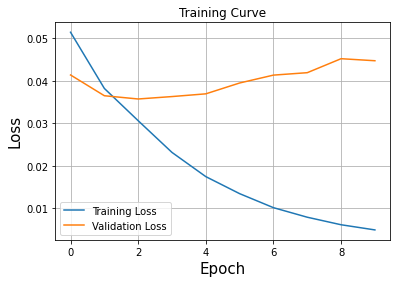

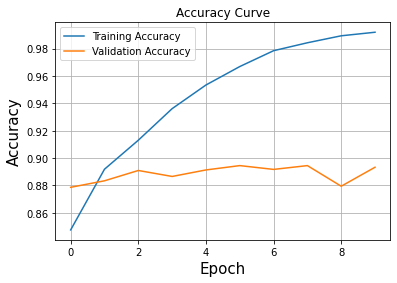

In [80]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn import BCEWithLogitsLoss
from torch.utils.data.sampler import BatchSampler, RandomSampler
train_set = encode_set["train"]
eval_set = encode_set["eval"]

train_sampler = BatchSampler(RandomSampler(train_set), batch_size=batch_size, drop_last=False)
train_loader = DataLoader(train_set, sampler=train_sampler)

validation_sampler = BatchSampler(RandomSampler(eval_set), batch_size=batch_size, drop_last=False)
validation_loader = DataLoader(eval_set, sampler=validation_sampler)

optimizer = AdamW(classifier.parameters(), lr=1e-5)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

classifier.to(device)
loss_function = BCEWithLogitsLoss()


def train_model(model, loader):
  model.train()
  total_loss = 0
  total_match = 0
  i = 0
  for batch in loader:
    #print(batch)
    i += 1
    optimizer.zero_grad()
    in_ = {k: v.squeeze().to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
    labels = batch["labels"].squeeze().to(device)
    #print(in_)
    outputs = model(**in_)
    loss = loss_function(outputs, labels)
    total_loss += loss.item()
    
    # Compute match
    prediction = torch.sigmoid(outputs) > 0.5
    match = prediction == labels
    total_match += match.sum().item()

    # tune
    loss.backward()
    optimizer.step()
  return total_loss / (len(loader) * batch_size), total_match/(len(loader)*batch_size*5)

def validate_model(model, loader):
  model.eval()
  total_loss = 0
  total_match = 0
  i = 0
  for batch in loader:
    in_ = {k: v.squeeze().to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
    labels = batch["labels"].squeeze().to(device)
    outputs = model(**in_)
    loss = loss_function(outputs, labels)
    total_loss += loss.item()

    # Compute match
    prediction = torch.sigmoid(outputs) > 0.5
    match = prediction == labels
    total_match += match.sum().item()
  return total_loss / (len(loader) * batch_size), total_match/(len(loader)*batch_size*5)


      

train_losses, validation_losses = [], []
train_accuracies, validation_accuracies = [], []
for _ in tqdm(range(10)):
  train_loss, train_accuracy = train_model(classifier, train_loader)
  print("Train Loss:", train_loss)
  print("Train Accuracy:", train_accuracy)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  validation_loss, validation_accuracy = validate_model(classifier, validation_loader)
  print("Validation Loss:", validation_loss)
  validation_losses.append(validation_loss)
  print("Validation Accuracy:", validation_accuracy)
  validation_accuracies.append(validation_accuracy)
fig_loss, plot_loss = plt.subplots()
fig_accuracy, plot_accuracy = plt.subplots()

plot_loss.plot(train_losses, label = "Training Loss")
plot_accuracy.plot(train_accuracies, label = "Training Accuracy")

plot_loss.plot(validation_losses, label = "Validation Loss")
plot_accuracy.plot(validation_accuracies, label = "Validation Accuracy")
    
plot_loss.legend()
plot_loss.set_xlabel('Epoch', fontsize=15)
plot_loss.set_ylabel('Loss', fontsize=15)
plot_loss.set_title('Training Curve')
plot_loss.grid(True)

plot_accuracy.legend()
plot_accuracy.set_xlabel('Epoch', fontsize=15)
plot_accuracy.set_ylabel('Accuracy', fontsize=15)
plot_accuracy.set_title('Accuracy Curve')
plot_accuracy.grid(True)

plt.show()
